In [1]:
import scipy.io as io
import numpy as np
import scipy.constants as cts
import matplotlib.pyplot as plt

In [2]:
FSR0 = 1e12*23e-6/23e-6
FSR0

1000000000000.0

In [3]:
res = dict(
        R=23e-6, 
        Qi=1e6, 
        Qc=1e6, 
        gamma=3.2, 
)

sim = dict(
    Pin=[240e-3], 
    f_pmp=[283e12],
    phi_pmp=[0], 
    del_omega=[None], 
    Tscan=0.7e6,
    mu_sim=[-220, 220],
    del_omega_init= 1e9 * 2 * np.pi,
    del_omega_end= -6.5e9 * 2 * np.pi,
    num_probe = 5000 
)
res,sim

({'R': 2.3e-05, 'Qi': 1000000.0, 'Qc': 1000000.0, 'gamma': 3.2},
 {'Pin': [0.24],
  'f_pmp': [283000000000000.0],
  'phi_pmp': [0],
  'del_omega': [None],
  'Tscan': 700000.0,
  'mu_sim': [-220, 220],
  'del_omega_init': 6283185307.179586,
  'del_omega_end': -40840704496.66731,
  'num_probe': 5000})

In [9]:
lines = open('RW1000_H430.csv', 'r').readlines()
rM = np.array([float(ll.strip().split(',')[0]) for ll in lines])  # azimuthal mode order
rf = np.array([float(ll.strip().split(',')[1]) for ll in lines])  # corresponding resonance frequencies

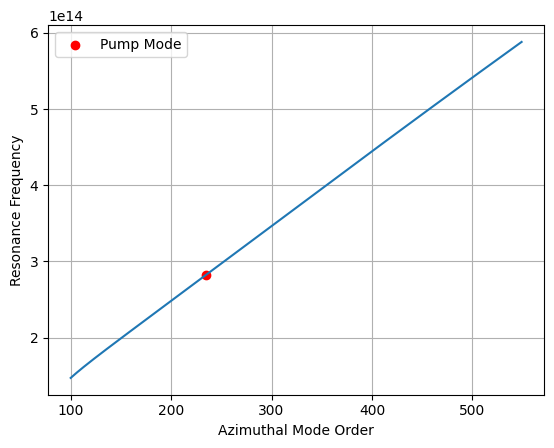

In [15]:
def plot_data(sim,res):
    FSR0 = 1e12 * 23e-6 / res['R']
    lines = open('RW1000_H430.csv', 'r').readlines()
    rM = np.array([float(ll.strip().split(',')[0]) for ll in lines])  # azimuthal mode order
    rf = np.array([float(ll.strip().split(',')[1]) for ll in lines])  # corresponding resonance frequencies

    # find the mode closest to the pump
    f_pmp = sim['f_pmp'][0]
    f_pmp_idx = np.argmin(np.abs(rf - f_pmp))
    f_pmp = rf[f_pmp_idx]
    rM_pmp = rM[f_pmp_idx]
    
    # plot the data
    plt.plot(rM, rf)
    plt.scatter(rM_pmp, f_pmp, color='red', label='Pump Mode')
    plt.xlabel('Azimuthal Mode Order')
    plt.ylabel('Resonance Frequency')
    plt.grid()
    plt.legend()
    plt.show()

    return f_pmp, rM_pmp, f_pmp_idx
# f_pmp, rM_pmp
f_pmp, rM_pmp, f_pmp_idx = plot_data(sim,res)

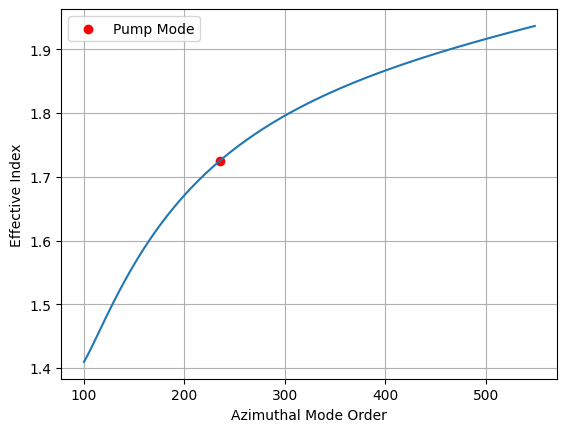

In [16]:
# function to calculate effective group index
def get_ngeff(rf,rM,rM_pmp,f_pmp_idx,res):
    L = 2*np.pi*res['R']
    df = np.gradient(rf) # calculate the mode spacing
    n_eff = rM*cts.c/(2*np.pi*rf*res['R']) # calculate the effective index  
    n_eff_pmp = n_eff[f_pmp_idx] # effective index at the pump
    n_g = cts.c/(df*L)
    ng_pmp = n_g[f_pmp_idx]
    tR = L*ng_pmp/cts.c

    # plot the effective index
    plt.plot(rM, n_eff)
    plt.scatter(rM_pmp, n_eff_pmp, color='red', label='Pump Mode')
    plt.xlabel('Azimuthal Mode Order')
    plt.ylabel('Effective Index')
    plt.grid()
    plt.legend()
    plt.show()

    return n_eff, n_eff_pmp, n_g, ng_pmp, tR
n_eff, n_eff_pmp, n_g, ng_pmp, tR=get_ngeff(rf,rM,rM_pmp,f_pmp_idx,res)

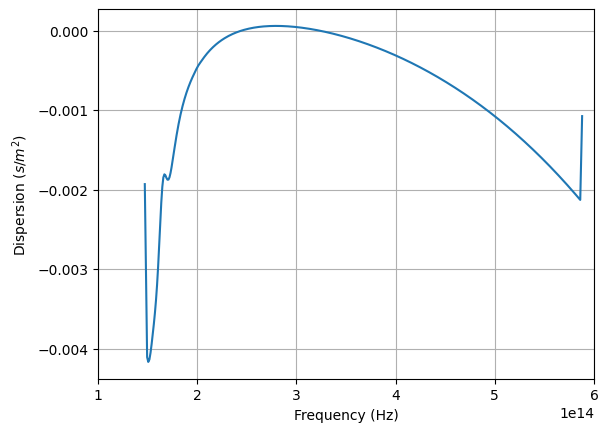

In [17]:
def get_dispersion(rf,ng):
    df = np.gradient(rf) # calculate the mode spacing
    d1_vg = np.gradient(ng)/cts.c
    D = -(rf**2/cts.c)*d1_vg/df
    plt.plot(rf, D)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'Dispersion ($s/m^2$)')
    plt.xlim(100e12,600e12)
    plt.grid()
    plt.show()
    return D
D = get_dispersion(rf,n_g)

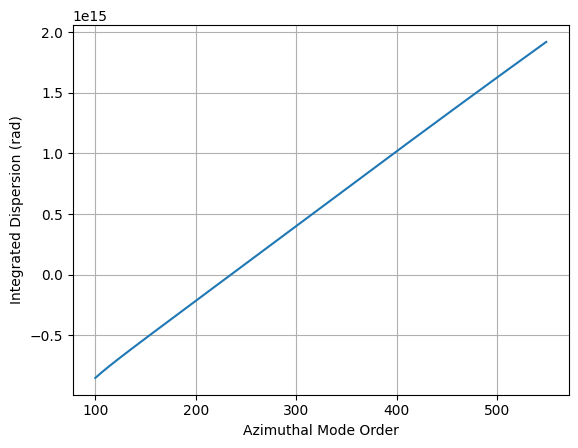

In [18]:
def get_integrated_dispersion(f_pmp_idx,rf,rM,ng_pmp):
    dm = np.arange(-2,3) # create a local window of modes around the pump for fitting the dispersion
    drf = rf - rf[f_pmp_idx] # calculate the frequency detuning from the pump
    Dfit = np.polyfit(drf[dm], D[f_pmp_idx+dm], 2) # fit a quadratic polynomial to the dispersion
    FSR = Dfit[1] # calculate the FSR
    D1 = FSR*2*np.pi # calculate the first order dispersion
    D2 = Dfit[0]*2*np.pi # calculate the GVD
    mu = rM-rM[f_pmp_idx] # calculate the azimuthal mode order detuning from the pump
    omega = 2*np.pi*rf # calculate the angular frequency
    D_int = omega-(omega[f_pmp_idx]+D1*mu)
    beta2 = -ng_pmp/cts.c*(2*Dfit[0])/Dfit[1]**2/2/np.pi
    
    # plot the integrated dispersion
    plt.plot(rM, D_int)
    plt.xlabel('Azimuthal Mode Order')
    plt.ylabel('Integrated Dispersion (rad)')
    plt.grid()
    plt.show()
    return mu, D_int, D1
mu, D_int, D1 = get_integrated_dispersion(f_pmp_idx,rf,rM,ng_pmp)

In [23]:
# import splrep
from scipy.interpolate import splrep, splev
def fit_Dint_domain(ind0,ind_master,Dint, mu, rM,rM_fit):
    mu_fit = rM_fit
    shift = ind0 - ind_master

    mu_fit = [rm-shift for rm in mu_fit]
    M = np.arange(ind0+mu_fit[0], ind0+mu_fit[1]+1,dtype=int)

    mu_select = np.arange(mu_fit[0],mu_fit[1]+1, dtype=int)
    print(M)
    assert M[0] >= 0 and M[-1] < len(mu), 'The selected domain is out of bounds'

    M2fit = rM[M] - rM[ind0]
    Dint2fit = Dint[M]
    fitfun = splrep(M2fit, Dint2fit)
    selected_fit = splev(mu_select, fitfun)
    f_pmp_idx = np.argwhere(mu_fit==0).flatten()[0]
    return fitfun, mu_select, selected_fit, f_pmp_idx

In [24]:
def do_fitsimulation_Dint(fitfun, ind0, ind_master, rM_sim):
    shift = ind0 - ind_master
    mu2_fit = [rm-shift for rm in rM_sim]
    ind_sim = np.arange(mu2_fit[0],mu2_fit[1]+1, dtype=int)
    Dint_fit = splev(mu2_fit, fitfun)
    pmp_ind = np.argwhere(ind_sim==0).flatten()[0]
    return mu2_fit, Dint_fit, pmp_ind

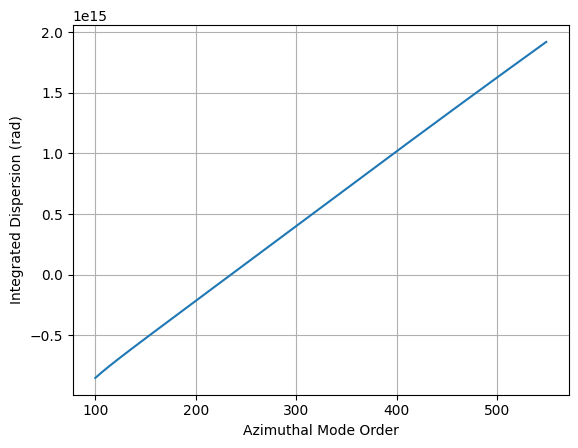

In [25]:
mu_, Dint_, D1_ = get_integrated_dispersion(f_pmp_idx,rf,rM,ng_pmp)

In [26]:
ff, mu_fit_, Dint_fit_, pmp_fit_ = fit_Dint_domain(f_pmp_idx, f_pmp_idx, Dint_, mu_, rM, sim['mu_sim'])

[-85 -84 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73 -72 -71 -70 -69 -68
 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50
 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32
 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14
 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4
   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 16

AssertionError: The selected domain is out of bounds

In [1]:
from scipy.constants import c, hbar, pi
c,hbar

(299792458.0, 1.0545718176461565e-34)

In [5]:
import numpy as np
import scipy.interpolate as itp
a = np.arange(1, 10, 1)
b = np.arange(1, 10, 1)
x= itp.splrep(a,b)